# Proyecto final: Análisis descriptivo, predictivo y prescriptivo sobre el precio del oro

Bienvenido! En este proyecto pondrás en práctica lo estudiado en el curso, que ya viste de forma práctica en los ejemplos. Utiliza las consignas que están en cada celda para paso a paso saber excatamente qué hacer. ¡Buena suerte! 


## Importar librerías

En la siguiente celda se encuentran las librerías que se necesitan para la solución, si necesitas otras no dudes en agregarlas.

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.metrics import mean_absolute_error,r2_score
from scipy import stats

# Análisis descriptivo

## Leer los datos

Después de importar las librerías descarga el archivo "gld_price_data.csv" de AGREGAR LINK y guardalos en la carpeta llamada "data" dentro de la misma carpeta donde se encuentre este código. En la siguiente línea usa la librería pandas para importar los datos y guardalos en un dataframe llamado df. Recuerda copiar el directorio exactamente como está en tu sistema. 

In [114]:
df = pd.read_csv('./data/gld_price_data.csv')

La siguiente información, muestra el significado de las columnas:
- SPX: índice de capitalización de las 500 mayores empresas cotizadas en EE.UU
- SLV: precio de la plata
- USO: precio del petróleo en EE.UU
- GLD: precio del oro
- EUR/USD: razón entre euroes y dólares.

Usa las funciones correspondientes para observar las primeras filas de la base de datos, y para saber cuántas filas y columnas tiene. A continuación, define la variable objetivo, en este caso queremos usar los datos para predecir el precio del oro "GLD".   

In [115]:
df.head()

Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099

In [116]:
df.shape

(2290, 6)

In [117]:
target = 'GLD' # Completa con el nombre de la variable objetivo

A continuación, veamos algunas estadísticas descriptivas de las columnas de df. 

In [118]:
df.describe()

SPX          GLD          USO          SLV      EUR/USD
count  2290.000000  2290.000000  2290.000000  2290.000000  2290.000000
mean   1654.315776   122.732875    31.842221    20.084997     1.283653
std     519.111540    23.283346    19.523517     7.092566     0.131547
min     676.530029    70.000000     7.960000     8.850000     1.039047
25%    1239.874969   109.725000    14.380000    15.570000     1.171313
50%    1551.434998   120.580002    33.869999    17.268500     1.303297
75%    2073.010070   132.840004    37.827501    22.882499     1.369971
max    2872.870117   184.589996   117.480003    47.259998     1.598798

## Preprocesamiento

Primero, elimina la columna "Date" que por el momento no nos aporta información. A continuación completa el código siguiente para eliminar las columnas con más de 80% de datos faltantes.

In [119]:
df.drop(columns='Date',inplace=True)

In [120]:
porcentaje_nulos = df.isnull().mean()*100
print(porcentaje_nulos)
df = df[df.columns[porcentaje_nulos <= 80]]
    
print('Cantidad de columnas restantes en df:',df.shape[1])

SPX        0.0
GLD        0.0
USO        0.0
SLV        0.0
EUR/USD    0.0
dtype: float64
Cantidad de columnas restantes en df: 5


Busquemos y eliminemos ahora filas duplicadas. 

In [121]:
df.drop_duplicates(inplace=True)
df.shape[0]

2290

Como vemos no hay datos nulos ni duplicados en esta base, por lo tanto no se eliminarán columnas, ni tampoco necesitaremos hacer imputación. Además, todas las variables de nuestra base son numéricas como se puede ver en la descripción. 

### Ouliers 
Como viste en los ejemplos, construye una tabla (dataframe) con la siguiente información: 
- Primer y tercer cuartil
- Rango intercuartílico
- Outliers superiores, es decir, aquellos valores que son mayores que tercer_cuartil+1.5*iqr
- Outliers inferiores, es decir, aquellos valores que son menores que primer_cuartil-1.5*iqr

Además, crea una lista con los índices que contengan valores menores que el límite inferior o mayores que el límite superior. 

In [122]:
tabla = pd.DataFrame(index=df.columns)
indices = []
for col in df.columns:
    tabla.loc[col,'primer_cuartil'] = np.percentile(df[col],25) 
    tabla.loc[col,'tercer_cuartil'] = np.percentile(df[col],75)
    tabla.loc[col,'iqr'] = stats.iqr(df[col])   
    lim_sup = tabla.loc[col,'tercer_cuartil']+tabla.loc[col,'iqr']*1.5
    lim_inf = tabla.loc[col,'primer_cuartil']-tabla.loc[col,'iqr']*1.5
    tabla.loc[col,'outliers_sup'] = len(df[df[col]>lim_sup])
    tabla.loc[col,'outliers_inf'] = len(df[df[col]<lim_inf])          
    indices += list(df[(df[col]>lim_sup) | (df[col]<lim_inf)].index)    
#         for i in df.index:
#             if  df.loc[i,col] > lim_sup:
#                 df.loc[i,col] = lim_sup
#             elif df.loc[i,col] < lim_inf:
#                   df.loc[i,col] = lim_inf    
tabla

primer_cuartil  tercer_cuartil         iqr  outliers_sup  \
SPX         1239.874969     2073.010070  833.135101           0.0   
GLD          109.725000      132.840004   23.115004          92.0   
USO           14.380000       37.827501   23.447501         134.0   
SLV           15.570000       22.882499    7.312499         117.0   
EUR/USD        1.171313        1.369971    0.198658           0.0   

         outliers_inf  
SPX               0.0  
GLD              23.0  
USO               0.0  
SLV               0.0  
EUR/USD           0.0

Si la cantidad de outliers es menor que el 20% (debe ser el caso), elimínalos y ve cuántas columnas quedaron en df. 

In [123]:
df.drop(indices,inplace=True)
df.shape

(1960, 5)

## Visualizaciones
Veamos paso a paso cómo se comportan nuestras variables.

Utiliza la función o las funciones convenientes para realizar un scatter plot de las columnas dos a dos, y las gráficas de histogramas y/o densidad de las columnas.

**Versión 1**

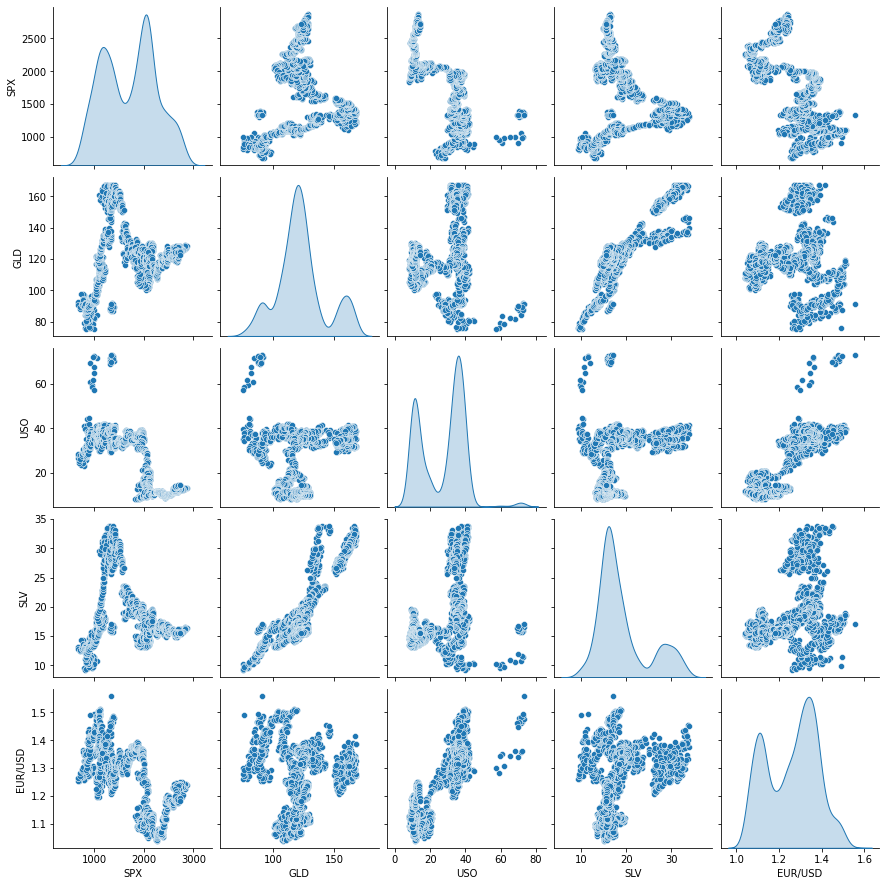

In [124]:
sns.pairplot(df,diag_kind='kde') # Borrar el parámetro "kde" para obtener los histogramas

**Versión 2**

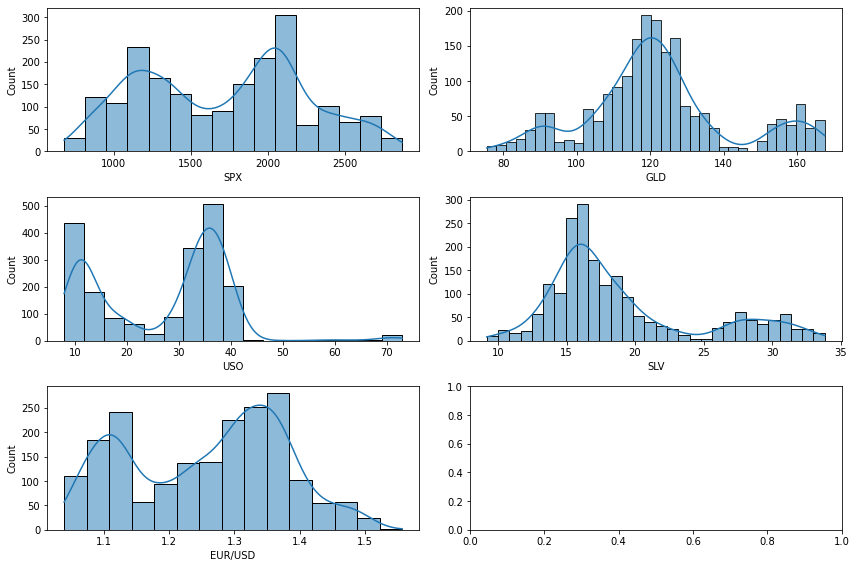

In [125]:
fig, ax = plt.subplots(3,2,figsize=(12,8))
vector = np.array(range(6)).reshape(3,2) # este vector se usa para obtener los índices del subplot
for index,col in enumerate(df.columns):
    i = np.where(vector==index)[0][0]
    j = np.where(vector==index)[1][0]
    sns.histplot(df[col],ax=ax[i,j],kde=True)
plt.tight_layout()
plt.show()  

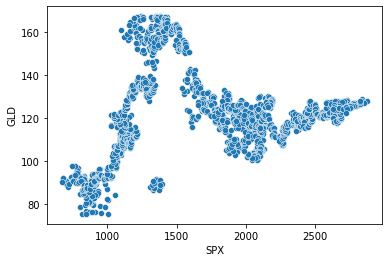

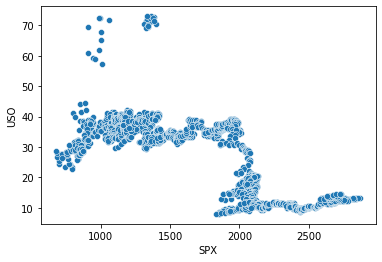

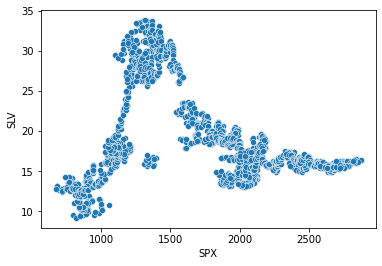

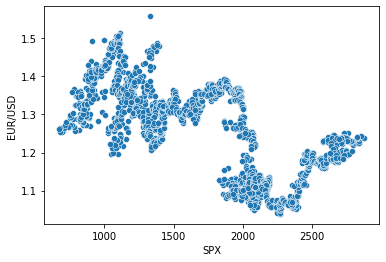

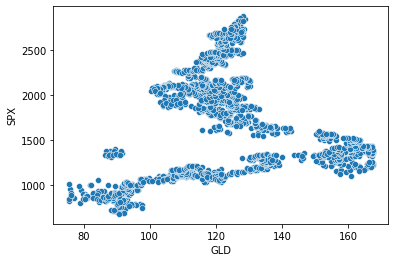

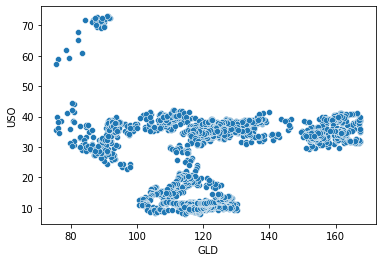

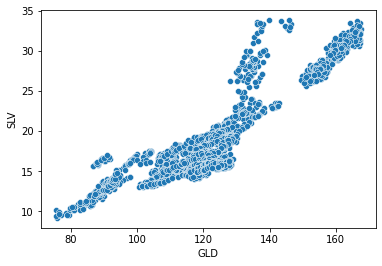

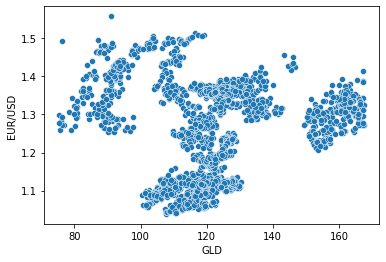

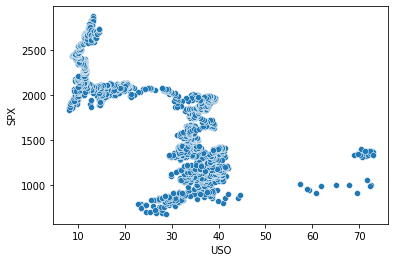

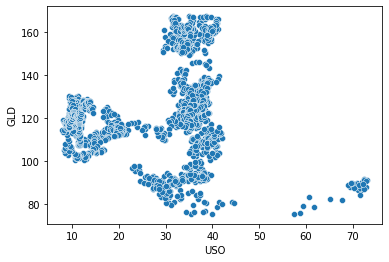

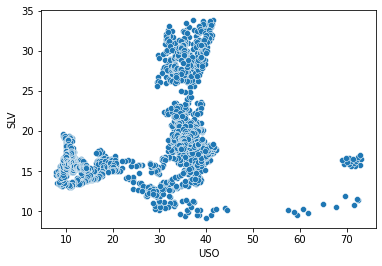

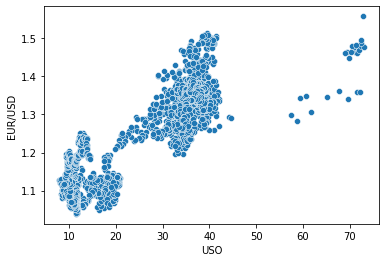

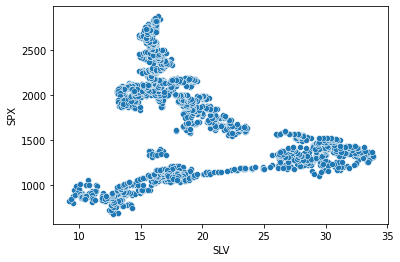

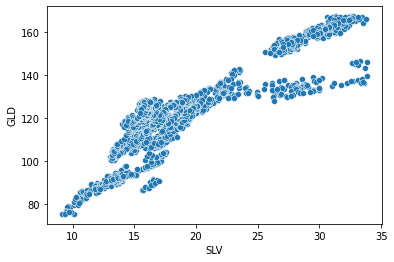

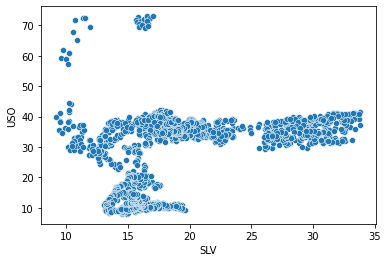

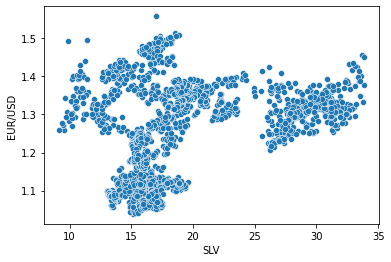

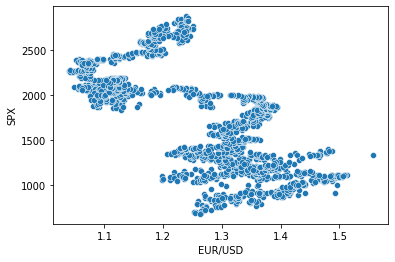

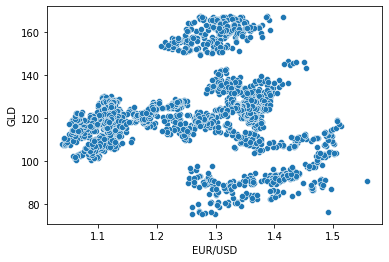

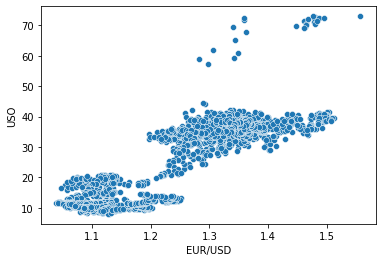

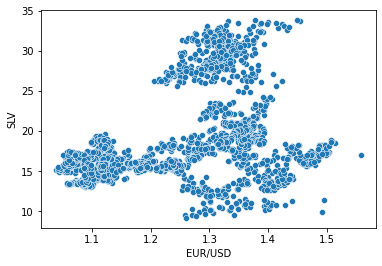

In [126]:
for col1 in df.columns:
    for col2 in df.columns:
        if col1 != col2:
            fig, ax = plt.subplots()
            sns.scatterplot(x=df[col1],y=df[col2],data=df,ax=ax)
plt.show()

### Correlación
En los gráficos de dispersión (scatter plot) se puede ver una correlación entre algunas de las variables, halla la matriz de correlación  y construye una gráfica de calor (heatmap). 

Sugerencia: Puedes utilizar la función corr() de pandas en Python o la función cor() de R para hallar la correlación y la función heatmap para graficar. 

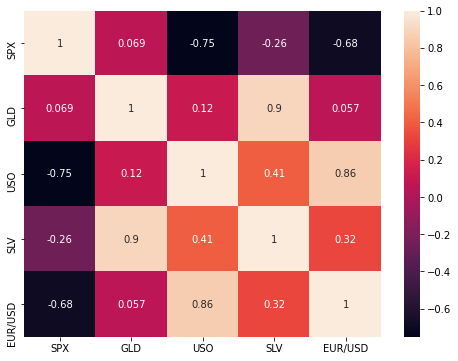

In [127]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df.corr(),annot=True)
plt.show()

## Entrenamiento de modelos y predicción

### Entrenamiento y evaluación
Divide los datos en subconjuntos de entrenamiento y prueba. Entrena los modelos vistos en los ejemplos, **Regresión Lineal**, **Random Forest**, **Gradient Boosting**  con un subconjunto de los datos y realiza predicciones en el conjunto de prueba. Halla la precisión de estos hallando el R cuadrado.

In [128]:
# LLama "X" al dataframe sin la variable objetivo, y "y" a la columna de la variable objetivo 
# y utiliza las funciones aprendidas para separar estas en subcinjuntos de entrenamiento y prueba

X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [129]:
# Regresión lineal

LR = LinearRegression()
LR = LR.fit(X_train,y_train)
LR_pred = LR.predict(X_test)
print("R^2 :",r2_score(y_test, LR_pred))

R^2 : 0.9254493423416795


In [130]:
# Random Forest

RF = RandomForestRegressor().fit(X_train,y_train)
RF_pred =  RF.predict(X_test) 
print("R^2 :",r2_score(y_test, RF_pred))

R^2 : 0.9828925091032564


In [131]:
# Gradient Boosting

XGB = GradientBoostingRegressor().fit(X_train,y_train)
XGB_pred =  XGB.predict(X_test) 
print("R^2 :",r2_score(y_test, XGB_pred))

R^2 : 0.9772923254835086


#### Conclusiones
¿Cuál es el mejor en cuanto a la medida de R^2?

In [132]:
print('El modelo que presenta mejor precisión es --- ') #Completar

El modelo que presenta mejor precisión es --- 


### Predicción
Carga los archivos en "gold_test.csv" en un dataframe llamado df_test y utilizando el modelo que elegiste en la celda anterior realiza una predicción con los nuevos datos y agregala como una nueva columna a df_test e imprime tu nuevo dataframe.

In [133]:
df_test = pd.read_csv('./data/gold_test.csv')
RF_pred =  RF.predict(df_test.drop(columns='Date'))
RF_pred = pd.Series(RF_pred,name='Price')
df_test = pd.concat([df_test,RF_pred],axis=1)
df_test

Date          SPX        USO        SLV   EUR/USD       Price
0     9/18/2014  2011.359985  34.619999  17.770000  1.292006  117.941401
1     9/16/2010  1124.660034  32.980000  20.350000  1.307600  126.012102
2     6/20/2016  2083.250000  11.910000  16.650000  1.132298  122.742199
3      6/4/2015  2095.840088  19.660000  15.480000  1.120787  113.172297
4     3/25/2013  1551.689941  33.849998  27.840000  1.302406  154.944203
...         ...          ...        ...        ...       ...         ...
1026  6/23/2010  1092.040039  34.240002  18.180000  1.233745  120.333499
1027  1/11/2016  1923.670044   9.250000  13.220000  1.094104  103.576999
1028  9/18/2012  1459.319946  35.570000  33.709999  1.304631  164.012199
1029   4/2/2013  1570.250000  34.650002  26.350000  1.282051  152.310597
1030   1/7/2016  1943.089966   9.900000  13.620000  1.077900  106.607201

[1031 rows x 6 columns]

## Prescripciones

Como vimos en los ejemplos, podemos usar los coeficientes de la regresión para saber cómo modificar valores en las variables de forma que aumente o disminuya la variable objetivo, en el caso de nuestra base no es tan probable que podamos cambiar las variables explicativas, sin embargo sigue siendo una información útil si deseamos invertir en oro. Observemos que en este caso la regresión lineal tiene una buena precisión, así que podemos utilizar los coeficientes. 

In [141]:
LR.coef_.flatten()
LR_coef = LR.coef_.flatten()
Coeficientes = pd.DataFrame({'Variable':X.columns,'Regresión Lineal':LR_coef})
Coeficientes = Coeficientes.sort_values(by=['Regresión Lineal'],ascending=False)
Coeficientes

Variable  Regresión Lineal
2      SLV          3.532038
0      SPX          0.009341
1      USO         -0.165780
3  EUR/USD         -0.940271

Guardemos esta table por el momento. Para comparar estos resultados usaremos la misma técnica de los ejemplos, convertir nuestra variable objetivo en binaria, siendo 1 si el precio está sobre la mediana y 0 en caso contrario. Juega a cambiar este valor por la media, u otros, para que observes como se modifican los resultados. 
A continuación, vuelve a entrenar el modelo, pero ahora usa una **regresión logística**. Halla su precisión utilizando la función **accuracy_score** de **metrics**.

In [135]:
med = y.median() 
for i in y.index:
    if y[i] > med:
        y[i] = 1
    else:     
        y[i] = 0 
        
log = LogisticRegression()
log = log.fit(X_train,y_train)
log_pred = log.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, log_pred))

Accuracy: 0.9149659863945578


Construye una columna con los coeficientes de la regresión logística y agrégala al dataframe "Coeficientes".Ten cuidado de hacer corresponder los coeficientes a las variables a las que corresponden.

In [143]:
log_coef = log.coef_.flatten()
log_coef = pd.DataFrame({'Variable':X.columns,'Regresión Logística':log_coef})
Coeficientes = Coeficientes.merge(log_coef,on='Variable')
Coeficientes

Variable  Regresión Lineal  Regresión Logística
0      SLV          3.532038             1.601567
1      SPX          0.009341             0.003415
2      USO         -0.165780            -0.076614
3  EUR/USD         -0.940271             2.848534

Grafica los coeficientes en un gráfico de barras.

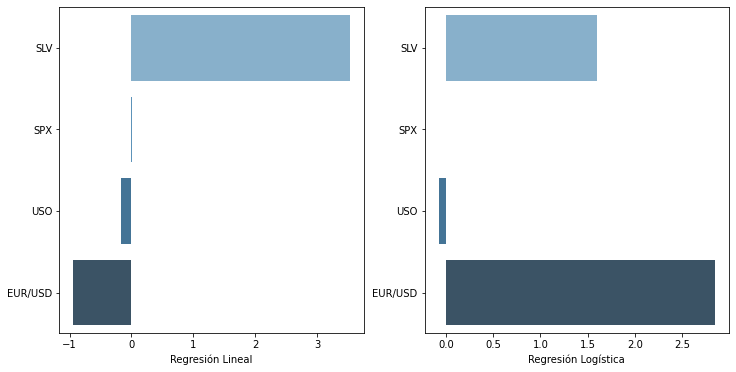

In [152]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
sns.barplot(y='Variable',x='Regresión Lineal',data=Coeficientes,palette="Blues_d",ax=ax[0])
ax[0].set(ylabel='')
sns.barplot(y='Variable',x='Regresión Logística',data=Coeficientes,palette="Blues_d",ax=ax[1])
ax[1].set(ylabel='')
plt.show()

### Conclusiones 

In [153]:
print('La variable que más impacta de forma positiva el precio del oro según la regresión lineal es ... ') # Completar R/El precio de la plata o SLV
print('La variable que más impacta de forma negativa el precio del oro es según la regresión lineal es ... ') # Completar R/La relación EUR/USD

print('La variable que más impacta de forma positiva el precio del oro según la regresión logística es ... ') # Completar R/La relación EUR/USD
print('La variable que más impacta de forma negativa el precio del oro es según la regresión logística es ... ') #Completar R/El precio del petróleo o USO

La variable que más impacta de forma positiva el precio del oro según la regresión lineal es ... 
La variable que más impacta de forma negativa el precio del oro es según la regresión lineal es ... 
La variable que más impacta de forma positiva el precio del oro según la regresión logística es ... 
La variable que más impacta de forma negativa el precio del oro es según la regresión logística es ... 


Recuerda que las variables que impactan de forma positiva son proporcionales a la variable objetivo, es decir, si la primera variable que elegiste aumenta, el precio aumenta. Y viceversa, las variables que impactan de forma negativa son inversamente proporcionales a la variable objetivo, es decir, si la primera variable que elegiste aumenta, el precio disminuye. En el caso de una variable objetivo binaria, usando una regresión logística, lo que aumenta o disminuye es la probabilidad de que la variable objetivo sea 1.    